In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import time
import pickle
import lime
import lime.lime_tabular

In [20]:
df = pd.read_csv('dogs_expenses_reviewed_bis.csv')

In [21]:
df.drop(columns=['Breed', 'genetic_ailments', 'ailments_count', 'vet_cost', 'food_cost', 'Cost_1_5', 'Cost_6_7', 'Cost_8_plus', 'liability_insurance', 'dog_tax', 'liability_insurance_year', 'dog_tax_year', 'health_insurance_cost', 'yearly_final_cost'], inplace=True)

# Calculation of target variable

In [22]:
# calculation of health score based on severity score (ailments) and the annual health insurance cost
df['health_severity_score'] = (df['severity_score'] +  df['health_insurance_annual'])

In [23]:
df.head()

,longevity,grooming_required,size_category,intelligence_category,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,incredibly_kifriendly_dogs,dog_friendly,...,tier,severity_score,health_insurance_annual,category_Companion Dogs,category_Herding Dogs,category_Hound Dogs,category_Sporting Dogs,category_Terrier Dogs,category_Working Dogs,health_severity_score
0,12.0,2,1,4,3,2,2,3,3,2,...,1,5,1148.0,1.0,0.0,0.0,0.0,0.0,0.0,1153.0
1,12.0,2,1,4,3,2,2,3,3,2,...,1,5,1148.0,1.0,0.0,0.0,0.0,0.0,0.0,1153.0
2,12.0,2,1,4,3,2,2,3,3,2,...,1,5,1148.0,1.0,0.0,0.0,0.0,0.0,0.0,1153.0
3,12.0,2,1,4,3,2,2,3,3,2,...,1,5,1148.0,1.0,0.0,0.0,0.0,0.0,0.0,1153.0
4,12.0,2,1,4,3,2,2,3,3,2,...,1,5,1148.0,1.0,0.0,0.0,0.0,0.0,0.0,1153.0


In [24]:
df.drop(columns=['severity_score', 'health_insurance_annual'], inplace=True)

# Binary score

In [25]:
#stablish threshold to binarize the score
threshold = df['health_severity_score'].median()
df['health_severity'] = df['health_severity_score'] > threshold
# Convert the boolean to integer (0 for low severity, 1 for high severity)
df['health_severity'] = df['health_severity'].astype(int)
# 'health_severity' is now the new target variable for binary classification

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190500 entries, 0 to 190499
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   longevity                   190500 non-null  float64
 1   grooming_required           190500 non-null  int64  
 2   size_category               190500 non-null  int64  
 3   intelligence_category       190500 non-null  int64  
 4   sensitivity_level           190500 non-null  int64  
 5   tolerates_being_alone       190500 non-null  int64  
 6   tolerates_cold_weather      190500 non-null  int64  
 7   tolerates_hot_weather       190500 non-null  int64  
 8   incredibly_kifriendly_dogs  190500 non-null  int64  
 9   dog_friendly                190500 non-null  int64  
 10  friendly_towarstrangers     190500 non-null  int64  
 11  potential_for_mouthiness    190500 non-null  int64  
 12  prey_drive                  190500 non-null  int64  
 13  tendency_to_ba

In [27]:
df.drop(columns=['dog_friendly', 'tier', 'health_severity_score'], inplace=True)

In [28]:
df['health_severity'].unique() #High severity = 1, low severity = 0

array([0, 1])

# Random forest classifier and feature importance

In [29]:
# Split data into features (X) and target (y)
X = df.drop('health_severity', axis=1)
y = df['health_severity']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Display the feature importances
print("### Feature Importances ###")
print(importance_df.head(50))  # Display top 50 features

### Feature Importances ###
                       feature  importance
0                    longevity    0.098617
2                size_category    0.097173
6       tolerates_cold_weather    0.076247
3        intelligence_category    0.067648
14              exercise_needs    0.060961
13        wanderlust_potential    0.056421
10    potential_for_mouthiness    0.053552
11                  prey_drive    0.053138
7        tolerates_hot_weather    0.048574
15                energy_level    0.044288
12    tendency_to_bark_or_howl    0.043209
5        tolerates_being_alone    0.041560
4            sensitivity_level    0.036072
9      friendly_towarstrangers    0.030588
1            grooming_required    0.030143
23       category_Working Dogs    0.028650
17                         age    0.027278
22       category_Terrier Dogs    0.022014
8   incredibly_kifriendly_dogs    0.021601
19       category_Herding Dogs    0.017662
21      category_Sporting Dogs    0.014496
20         category_Hound 

In [30]:
# Save
with open('X_scaled.pkl', 'wb') as f:
    pickle.dump(X_scaled, f)
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)
with open('rf_feature_importance.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('feature_importances.pkl', 'wb') as f:
    pickle.dump(feature_importances, f)
with open('importance_df.pkl', 'wb') as f:
    pickle.dump(importance_df, f)
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)

In [12]:
# Load
with open('X_scaled.pkl', 'rb') as f:
    X_scaled = pickle.load(f)
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('rf_feature_importance.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('feature_importances.pkl', 'rb') as f:
    feature_importances = pickle.load(f)
with open('importance_df.pkl', 'rb') as f:
    importance_df = pickle.load(f)
with open('random_forest_model.pkl', 'rb') as model_file:
    loaded_rf = pickle.load(model_file)

# Display the feature importances
print("### Feature Importances ###")
print(importance_df.head(50))  # Display top 50 features

### Feature Importances ###
                       feature  importance
0                    longevity    0.098617
2                size_category    0.097173
6       tolerates_cold_weather    0.076247
3        intelligence_category    0.067648
14              exercise_needs    0.060961
13        wanderlust_potential    0.056421
10    potential_for_mouthiness    0.053552
11                  prey_drive    0.053138
7        tolerates_hot_weather    0.048574
15                energy_level    0.044288
12    tendency_to_bark_or_howl    0.043209
5        tolerates_being_alone    0.041560
4            sensitivity_level    0.036072
9      friendly_towarstrangers    0.030588
1            grooming_required    0.030143
23       category_Working Dogs    0.028650
17                         age    0.027278
22       category_Terrier Dogs    0.022014
8   incredibly_kifriendly_dogs    0.021601
19       category_Herding Dogs    0.017662
21      category_Sporting Dogs    0.014496
20         category_Hound 

## Classification report

### Classification Report ###
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20419
           1       1.00      1.00      1.00     17681

    accuracy                           1.00     38100
   macro avg       1.00      1.00      1.00     38100
weighted avg       1.00      1.00      1.00     38100

ROC AUC Score: 1.0000


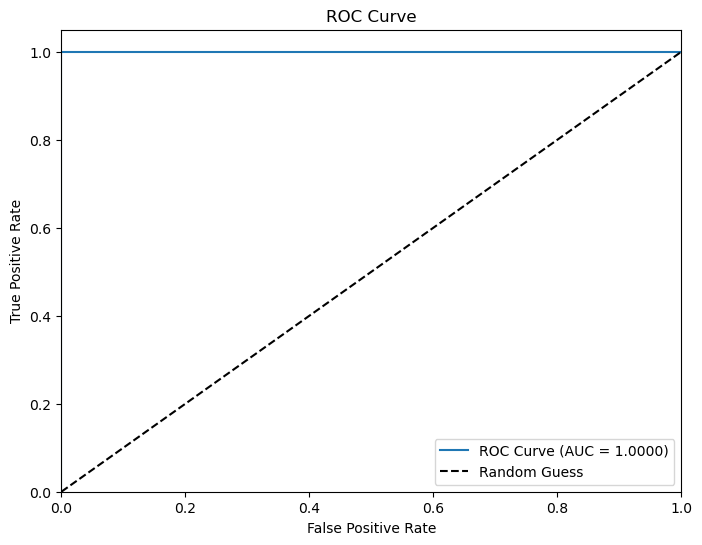

In [31]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
# Predictions on the test set
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Classification report
print("### Classification Report ###")
print(classification_report(y_test, y_pred))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Loading the model and scaler
with open('random_forest_model.pkl', 'rb') as model_file:
    loaded_rf = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)

print("Model and scaler loaded successfully.")

# Transform test data using the loaded scaler
X_test_scaled = loaded_scaler.transform(X_test)

# Make predictions using the loaded model
loaded_y_pred = loaded_rf.predict(X_test_scaled)
loaded_y_pred_prob = loaded_rf.predict_proba(X_test_scaled)[:, 1]

# Verify the predictions match
print("### Loaded Model Classification Report ###")
print(classification_report(y_test, loaded_y_pred))
loaded_roc_auc = roc_auc_score(y_test, loaded_y_pred_prob)
print(f"Loaded Model ROC AUC Score: {loaded_roc_auc:.4f}")

Model and scaler loaded successfully.


C:\Users\Vero\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Loaded Model Classification Report ###
              precision    recall  f1-score   support

           0       0.68      0.85      0.76     20419
           1       0.76      0.54      0.63     17681

    accuracy                           0.71     38100
   macro avg       0.72      0.70      0.69     38100
weighted avg       0.72      0.71      0.70     38100

Loaded Model ROC AUC Score: 0.7646


# Cross-validation

### Cross-Validation Scores (AUC) ###
[0.81284402 0.79371676 0.74240547 0.67848494 0.69157041]
Mean AUC: 0.7438
Standard Deviation AUC: 0.0534
Model and scaler saved successfully.
### Classification Report ###
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20419
           1       1.00      1.00      1.00     17681

    accuracy                           1.00     38100
   macro avg       1.00      1.00      1.00     38100
weighted avg       1.00      1.00      1.00     38100

ROC AUC Score: 1.0000


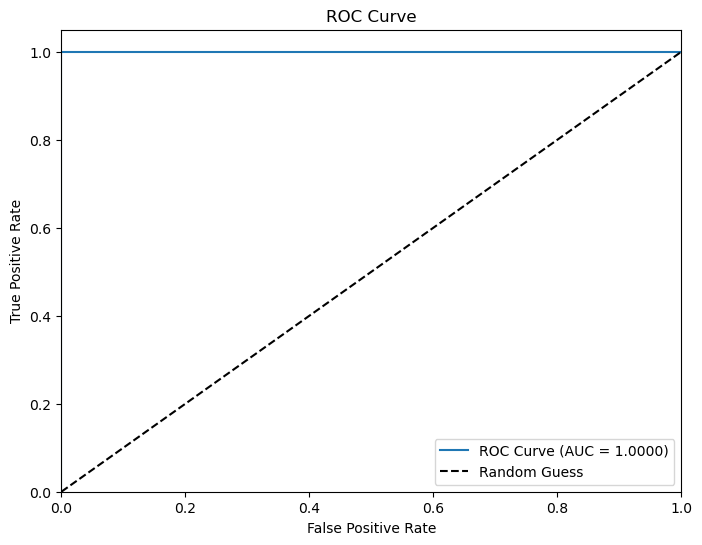

In [33]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')

# Print cross-validation scores
print("### Cross-Validation Scores (AUC) ###")
print(cv_scores)
print(f"Mean AUC: {cv_scores.mean():.4f}")
print(f"Standard Deviation AUC: {cv_scores.std():.4f}")

# Fit the model on the entire dataset
rf.fit(X_scaled, y)

# Save the Random Forest model and StandardScaler
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler saved successfully.")

# Split data into training and testing sets for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Make predictions on the test set
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Generate the classification report
print("### Classification Report ###")
print(classification_report(y_test, y_pred))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Loading the model and scaler
with open('logistic_regression_model.pkl', 'rb') as model_file:
    loaded_lr = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)

print("Model and scaler loaded successfully.")

# Logistic regression (Cross-validation)

### Cross-Validation Scores (AUC) ###
[0.64048978 0.72754026 0.63176795 0.54849899 0.52785082]
Mean AUC: 0.6152
Standard Deviation AUC: 0.0716
Model and scaler saved successfully.
### Classification Report ###
              precision    recall  f1-score   support

           0       0.72      0.75      0.74     20419
           1       0.70      0.66      0.68     17681

    accuracy                           0.71     38100
   macro avg       0.71      0.71      0.71     38100
weighted avg       0.71      0.71      0.71     38100

ROC AUC Score: 0.8069


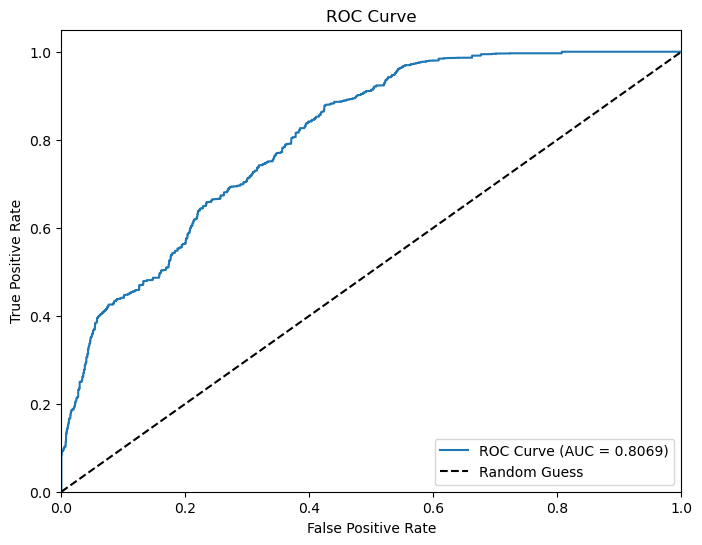

In [21]:
# Define the Logistic Regression model
lr = LogisticRegression(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='roc_auc')

# Print cross-validation scores
print("### Cross-Validation Scores (AUC) ###")
print(cv_scores)
print(f"Mean AUC: {cv_scores.mean():.4f}")
print(f"Standard Deviation AUC: {cv_scores.std():.4f}")

# Fit the model on the entire standardized dataset
lr.fit(X_scaled, y)

# Save the Logistic Regression model and StandardScaler
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(lr, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler saved successfully.")

# Split data into training and testing sets for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Make predictions on the test set
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)[:, 1]

# Generate the classification report
print("### Classification Report ###")
print(classification_report(y_test, y_pred))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Loading the model and scaler
with open('logistic_regression_model.pkl', 'rb') as model_file:
    loaded_lr = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)

print("Model and scaler loaded successfully.")

# Logistic Regression model with class weights

In [22]:
# Balanced datat with Class weights
# Define the Logistic Regression model with class weights
lr_balanced = LogisticRegression(random_state=42, class_weight='balanced')

# Perform cross-validation
cv_scores_balanced = cross_val_score(lr_balanced, X_scaled, y, cv=5, scoring='roc_auc')

# Print cross-validation scores
print("### Cross-Validation Scores (AUC) with Balanced Class Weights ###")
print(cv_scores_balanced)
print(f"Mean AUC: {cv_scores_balanced.mean():.4f}")
print(f"Standard Deviation AUC: {cv_scores_balanced.std():.4f}")

# Fit the model on the entire standardized dataset
lr_balanced.fit(X_scaled, y)

# Save the Logistic Regression model and StandardScaler
with open('logistic_regression_balanced_model.pkl', 'wb') as model_file:
    pickle.dump(lr_balanced, model_file)

print("Balanced model and scaler saved successfully.")

### Cross-Validation Scores (AUC) with Balanced Class Weights ###
[0.63948701 0.73019646 0.63120315 0.55111711 0.52770767]
Mean AUC: 0.6159
Standard Deviation AUC: 0.0719
Balanced model and scaler saved successfully.


In [ ]:
# Loading the model 
with open('logistic_regression_balanced_model.pkl', 'rb') as model_file:
    loaded_lr = pickle.load(model_file)

# Grid search (LR)

In [34]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}

# Initialize the Logistic Regression model with balanced class weights
lr = LogisticRegression(random_state=42, class_weight='balanced')

# Set up the GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc')

# Perform the grid search
grid_search.fit(X_scaled, y)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation AUC: ", grid_search.best_score_)

# Use the best model for final training
best_lr = grid_search.best_estimator_

# Save the best model and scaler
with open('best_logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(best_lr, model_file)

print("Best model and scaler saved successfully.")

Best Parameters:  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation AUC:  0.6229830458624127
Best model and scaler saved successfully.


In [ ]:
# Loading the model 
with open('best_logistic_regression_model.pkl', 'rb') as model_file:
    loaded_lr = pickle.load(model_file)

### Classification Report for Best Logistic Regression ###
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     20419
           1       0.66      0.71      0.68     17681

    accuracy                           0.70     38100
   macro avg       0.70      0.70      0.70     38100
weighted avg       0.70      0.70      0.70     38100

ROC AUC Score: 0.8045


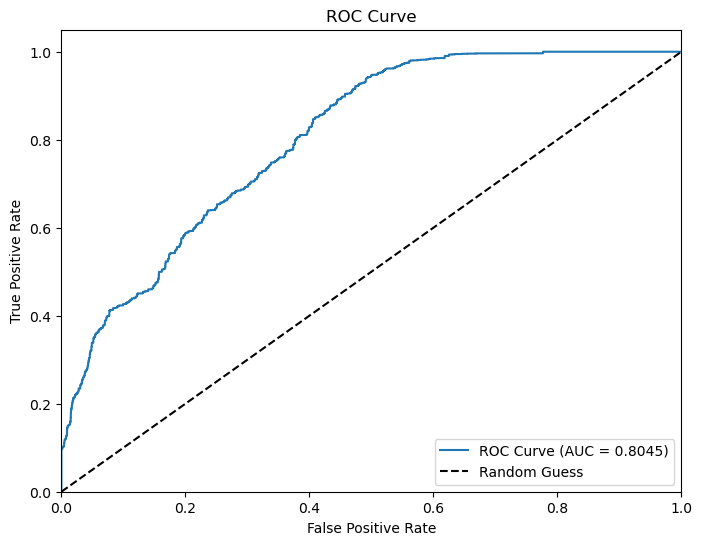

In [35]:
# Split data into training and testing sets for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the best model on the training data
best_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_lr.predict(X_test)
y_pred_prob = best_lr.predict_proba(X_test)[:, 1]

# Generate the classification report
print("### Classification Report for Best Logistic Regression ###")
print(classification_report(y_test, y_pred))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross validation with Gradient Boosting Classifier

In [36]:
# Cross validation with Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Define the GBM model
gbm = GradientBoostingClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(gbm, X_scaled, y, cv=5, scoring='roc_auc')

# Print cross-validation scores
print("### Cross-Validation Scores (AUC) ###")
print(cv_scores)
print(f"Mean AUC: {cv_scores.mean():.4f}")
print(f"Standard Deviation AUC: {cv_scores.std():.4f}")

### Cross-Validation Scores (AUC) ###
[0.70585514 0.75835648 0.68035704 0.66656849 0.70124045]
Mean AUC: 0.7025
Standard Deviation AUC: 0.0314


# Gradient Boosting Classifier

In [40]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the GBM model
gbm = GradientBoostingClassifier(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, n_iter=5, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)

# Perform the random search
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Cross-Validation AUC: ", random_search.best_score_)

# Use the best model for final training
best_gbm = random_search.best_estimator_

# Save the best model and scaler
with open('best_gbm_model.pkl', 'wb') as model_file:
    pickle.dump(best_gbm, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Best GBM model and scaler saved successfully.")

# Evaluate the model
train_accuracy = best_gbm.score(X_train, y_train)
test_accuracy = best_gbm.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

Best Parameters:  {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01}
Best Cross-Validation AUC:  1.0
Best GBM model and scaler saved successfully.
Training Accuracy: 0.9953608923884515
Testing Accuracy: 0.9949606299212599


In [ ]:
# Loading the model 
with open('best_gbm_model.pkl', 'rb') as model_file:
    loaded_lr = pickle.load(model_file)

In [41]:
# Final training using best_gbm from GridSearchCV
best_gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=200,
                           random_state=42)

## Classification report

### Classification Report for Best GBM ###
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20419
           1       0.99      1.00      0.99     17681

    accuracy                           0.99     38100
   macro avg       0.99      1.00      0.99     38100
weighted avg       1.00      0.99      0.99     38100

ROC AUC Score: 1.0000


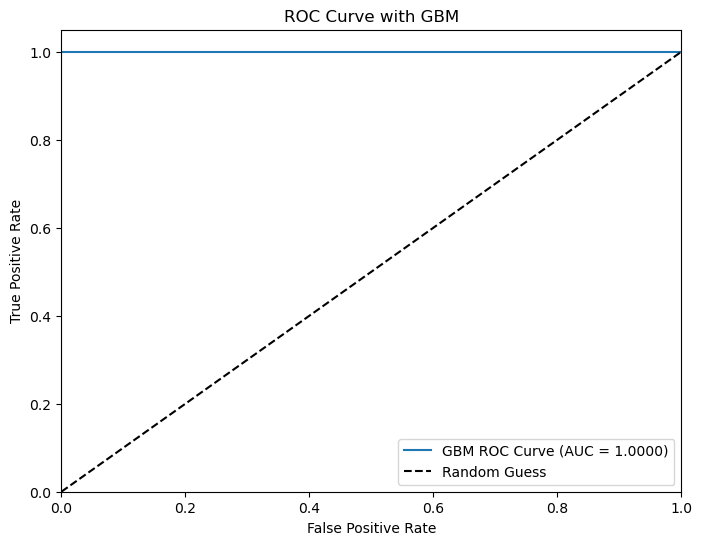

In [42]:
# Make predictions on the test set
y_pred_gbm = best_gbm.predict(X_test)
y_pred_prob_gbm = best_gbm.predict_proba(X_test)[:, 1]

# Generate the classification report
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print("### Classification Report for Best GBM ###")
print(classification_report(y_test, y_pred_gbm))

# Compute ROC AUC score
roc_auc_gbm = roc_auc_score(y_test, y_pred_prob_gbm)
print(f"ROC AUC Score: {roc_auc_gbm:.4f}")

# Plot ROC curve
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_prob_gbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm, tpr_gbm, label=f'GBM ROC Curve (AUC = {roc_auc_gbm:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with GBM')
plt.legend(loc='lower right')
plt.show()